<a href="https://colab.research.google.com/github/samiul272/ColabNotebooks/blob/master/Multi_Agent_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from IPython.display import clear_output
class environment:
    ''' Environment Model '''
    def __init__(self, phi,N):
        self.phi = phi
        self.N = N
        self.B = np.random.random_sample((self.N,1))
        self.state = np.zeros((1,1))
        self.reward_coeff = np.random.random_sample((self.N, 3))
    def step(self, action):
        self.action = action
        self.state = self.phi*abs(self.state) + self.B.T.dot(action) + math.sqrt(1-self.phi**2)*np.random.random_sample()#normal(0,1)
        self.reward = self.reward_fun()
        return self.state, self.reward
    def reward_fun(self):
        Re = self.R_fun(self.state, self.action)
        return np.random.random_sample((self.N, 1)) + Re - 0.5
    def R_fun(self, s, a):
        Re = np.zeros((self.N, 1));
        K = self.reward_coeff;
        for i in range(len(Re)):
            Re[i] = K[i,0] + K[i,1]*a[i]**2 + K[i,2]*s**2
        return Re
def Psi(s):
    return np.array([[gRBF(s, muPsi[i,j], 0.1) for j in range(N)] for i in range(mi)])
def gRBF(x,c,r):
    return math.exp(-np.linalg.norm(x-c)**2/r**2)
def E(s):
    return np.array([[gRBF(s, muE[i,j], 0.1) for j in range(N)] for i in range(N)])
def F(s):
    return np.array([[gRBF(s, muF[i,j], 0.1) for j in range(K-2)] for i in range(N)])
def Q(s,a,w):
    Qw = np.zeros((N,1))
    for i in range(N):
        wi = w[:,i].reshape((K,1))
        Qw[i] = wi[0]*a.T@E(s)@a + a.T@F(s)@wi[1:K-1,0] + wi[K-1]
    return Qw
def gradQ(s,a,w,theta):
    Es = E(s);
    Fs = F(s);
    eta = etaTheta(s,theta)
    GQ = np.zeros((N,1))
    for i in range(N):
        wi = w[:,i].reshape(K,1)
        Eii = Es[i,i]
        Eii_ = Es[i,[j for j in range(N) if j is not i]]
        Ei_i = Es[[j for j in range(N) if j is not i],i]
        Etii = (Eii_ + Ei_i.T)/2
        ai_ = a[[j for j in range(N) if j is not i]]
        Fi = Fs[i]
        GQ[i] = wi[0]*(2*Eii*eta[i]+Etii@ai_)+Fi@wi[1:K-1]
    return GQ
def GQw(s,a):
    gQw = np.zeros((K,1))
    gQw[0] = a.T@E(s)@a
    gQw[1:K-1,0] = np.transpose(a.T@F(s))
    gQw[K-1] = 1
    return np.repeat(gQw, N, axis=1)
def IQi_t(s,a,w,theta):
    GQ = gradQ(s,a,w,theta)
    PSI = Psi(s)
    return np.array([PSI[:,i]*GQ[i] for i in range(N)]).T
def Bwt(t):
    return 1/(t+1)**0.65
def Btht(t):
    return 1/(t+1)**0.85
def agents_policy(s, theta):
    eta = etaTheta(s,theta)
    action = np.array([np.random.normal(eta[i],0.1) for i in range(N)])
    return action
def etaTheta(s,theta):
    PSI = Psi(s)
    return np.array([np.dot(theta[:,i],PSI[:,i]) for i in range(N)])
def uniqueRandomInt(num, start = 1, end = 100): 
    arr = [] 
    tmp = np.random.randint(start, end) 
    for x in range(num):    
        while tmp in arr: 
            tmp = np.random.randint(start, end)    
        arr.append(tmp)    
    arr.sort()
    return arr
def getMarkovNet(N, ratio):
    E = int(np.floor(N*(N-1)*ratio/2))
    L = uniqueRandomInt(E,0,N*(N-1)/2)
    Ct = np.zeros((N,N))
    for i in range(N):
        Ct[i,i] = 1
        for j in range(i,N):
            k = i*N+j-(i+1)*(i+2)/2
            if k in L:
                Ct[i,j] = 1
                Ct[j,i] = 1
    return Ct
def clearScreen():
    clear_output()

In [2]:
''' Initialize the Gradient Policy '''
N = 10          # Number og agents
mi = 5          # Number of psi
K = 5           # dimension on wi

muPsi = np.random.random_sample((mi, N))    # mean of RBF for Psi(s)
muE = np.random.random_sample((N, N))       # mean of RBF for E(s)
muE = (muE + muE.T)/2                       # E(s) must be symmetric
muF = np.random.random_sample((N, K-2))     # mean of RBF for f(S)

''' Define Environment '''
phi = 0.9
env = environment(phi,N)
ratio = 0.1
Ct = getMarkovNet(N, ratio)

NUM_EPISODES = 1400                  # Number of Iteration

''' Initialize variables '''
mu_t = np.random.random_sample((N,1))
delta_t = np.random.random_sample((N,1))
theta = np.random.random_sample((mi,N))
wt = np.random.random_sample((K, N))
w_tilda = np.zeros((K, N))

MonteCarloMaxIter = 5
Jmin = 10*np.ones((NUM_EPISODES,1))
Jmax = -10*np.ones((NUM_EPISODES,1))
Jmean = np.zeros((NUM_EPISODES,1))
for it in range(MonteCarloMaxIter):
    ''' Varibale to store values in simulation'''
    reward = np.zeros((N,NUM_EPISODES))
    states = np.zeros((NUM_EPISODES,1))
    actions = np.zeros((N,NUM_EPISODES))
    Qvalue = np.zeros((N,NUM_EPISODES))
    time = np.zeros((NUM_EPISODES,1))
    J = np.zeros((NUM_EPISODES,1))
    Jt = 0              # Average return

    s = env.state
    ''' Algorithm 2 '''
    for t in range(1,NUM_EPISODES):
        '''Action Selector'''
        a = agents_policy(s,theta)
        ''' Observe state '''
        st, rt = env.step(a)
        ''' Update mu '''
        mu_t = (1-Bwt(t))*mu_t + Bwt(t)*rt
        ''' new action '''
        at = agents_policy(st,theta)

        ''' Update delta_t '''
        delta_t = rt - mu_t + Q(st,at,wt) - Q(s,a,wt)

        ''' Critic Step '''
        gQw = GQw(s,a)
        for i in range(N):
            w_tilda[:,i] = wt[:,i] + Bwt(t)*delta_t[i]*gQw[:,i]
        ''' Actor Step '''
        theta = theta + Btht(t)*IQi_t(s,a,wt,theta)
        ''' Consensus step '''
        wt = w_tilda@Ct
        for i in range(N):
            wt[:,i] = wt[:,i]/np.sum(Ct[i])

        ''' store states and actions'''
        s = st
        reward[:,t] = rt[:,0]
        states[t] = st
        time[t] = t
        Jt = t*Jt/(t+1) + mean(rt[:,0])/(t+1)
        J[t] = Jt
        Qvalue[:,t] = Q(s,a,wt)[:,0]
        print('iter = ',it,'EP = ',t,'st = ', st[0,0], 'Jt = ',  Jt )
    clearScreen()
    Jmin = np.minimum(Jmin,J)
    Jmax = np.maximum(Jmax,J)
    Jmean = it*Jmean/(it+1)+J/(it+1)

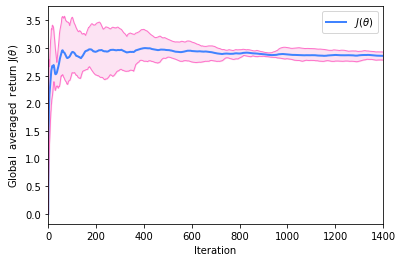

In [3]:
plt.figure()
plt.plot(time,Jmean,label = r'$J(\theta)$', color = '#4083ff',  linewidth = 2)
plt.plot(time,Jmax, color = '#ff73ca', linewidth = 1)
plt.plot(time,Jmin, color = '#ff73ca', linewidth = 1)
plt.fill_between(time[:,0], Jmin[:,0], Jmax[:,0], alpha = 0.2, color = '#f277c3')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'Global  averaged  return J($\theta$)')
plt.xlim([0, NUM_EPISODES])
plt.show()

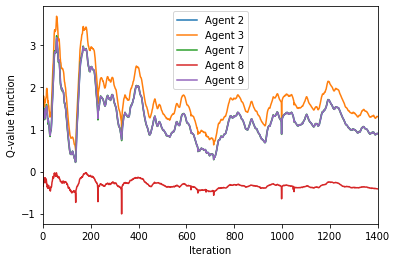

In [4]:
AgentQ = uniqueRandomInt(5,0,N)
plt.figure()
for agent in AgentQ:
    plt.plot(time,Qvalue[agent],label = "Agent " + str(agent+1) )
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Q-value function')
plt.xlim([0, NUM_EPISODES])
plt.show()